In [56]:
import sys
%cd variational_inference_for_longitudinal_data/
sys.path.append('variational_inference_for_longitudinal_data/')
sys.path.append('lib/')
sys.path.append('lib/src/')
sys.path.append('variational_inference_for_longitudinal_data/lib/src/pythae')
import torch
from torch import nn
import os
from matplotlib import pyplot as plt
import lightning as L
from sklearn.decomposition import PCA

from lib.src.pythae.models import VAE
from lib.scripts.utils import Encoder_Chairs,Decoder_Chairs, My_Dataset, My_MaskedDataset, make_batched_masks
from lib.src.pythae.models.vae import VAEConfig
from lib.src.pythae.trainers import BaseTrainerConfig
from lib.src.pythae.pipelines.training import TrainingPipeline
from lib.src.pythae.samplers.normal_sampling import NormalSampler
from lib.src.pythae.samplers.manifold_sampler import RHVAESampler

sys.path.append('diffusion/stable_diffusion/')
sys.path.append('diffusion/stable_diffusion/model/')
from diffusion.stable_diffusion.latent_diffusion import LatentDiffusion, DiffusionWrapper, MyLatentDiffusion, LitLDM
from diffusion.stable_diffusion.model.autoencoder import Autoencoder
from diffusion.stable_diffusion.model.clip_embedder import CLIPTextEmbedder
from diffusion.stable_diffusion.model.unet import UNetModel, _test_time_embeddings
from diffusion.stable_diffusion.sampler.ddim import DDIMSampler
from diffusion.stable_diffusion.sampler.ddpm import DDPMSampler

%reload_ext autoreload
%autoreload 2

!nvidia-smi

[Errno 2] No such file or directory: 'variational_inference_for_longitudinal_data/'
/home/mtayebje/variational_inference_for_longitudinal_data
Thu May 30 15:39:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.29.02              Driver Version: 545.29.02    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro RTX 8000                On  | 00000000:25:00.0 Off |                    0 |
| N/A   28C    P0              57W / 250W |    239MiB / 46080MiB |      0%      Default |
|              

In [2]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
train_data = torch.load(os.path.join('sprites/Sprites_train.pt'))[:-1000, -1, :, :, :].to(device) #only keeping the last frame of each sequence
eval_data = torch.load(os.path.join('sprites/Sprites_train.pt'), map_location="cpu")[-1000:, -1, :, :, :].to(device)
#test_data = torch.load(os.path.join('lib/my_data/sprites/Sprites_test.pt'), map_location="cpu")[:, -1, :, :, :].to(device)
print(train_data.shape)
train_data = train_data.permute(0, 3, 1, 2)
eval_data = eval_data.permute(0, 3, 1, 2)
#test_data = test_data.permute(0, 3, 1, 2)
print(train_data.shape)

train_seq_mask = torch.ones(train_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
eval_seq_mask = torch.ones(eval_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
#test_seq_mask = torch.ones(test_data.shape[:2], requires_grad=False).type(torch.bool).to(device)
train_pix_mask = torch.ones_like(train_data, requires_grad=False).type(torch.bool).to(device)
eval_pix_mask = torch.ones_like(eval_data, requires_grad=False).type(torch.bool).to(device)
#test_pix_mask = torch.ones_like(test_data, requires_grad=False).type(torch.bool).to(device)

train_dataset = My_MaskedDataset(train_data, train_seq_mask, train_pix_mask)
eval_dataset = My_MaskedDataset(eval_data, eval_seq_mask, eval_pix_mask)
#test_dataset = My_MaskedDataset(test_data, test_seq_mask, test_pix_mask)

torch.Size([8000, 64, 64, 3])
torch.Size([8000, 3, 64, 64])


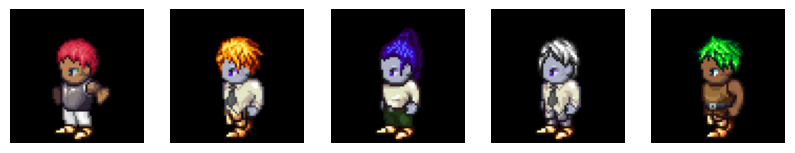

In [3]:
#check
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(train_dataset[i][0].data.cpu().permute(1, 2, 0))
    plt.axis('off')
plt.show()

In [4]:
input_dim = (3, 64, 64)
f = 8 #subsampling factor
latent_dim = 3* (64 // f) * (64 // f)
print('Latent dim:', latent_dim)

training_config = BaseTrainerConfig(output_dir='my_model',
num_epochs=100,
learning_rate=1e-3,
per_device_train_batch_size=200,
per_device_eval_batch_size=200,
train_dataloader_num_workers=2,
eval_dataloader_num_workers=2,
steps_saving=50,
optimizer_cls="AdamW",
optimizer_params={"weight_decay": 0.05, "betas": (0.91, 0.995)},
scheduler_cls="ReduceLROnPlateau",
scheduler_params={"patience": 5, "factor": 0.5})


Latent dim: 192


In [13]:
device = 'cuda'
vae = VAE.load_from_folder('pre-trained_vae/VAE_training_2024-05-22_14-43-10/final_model').to(device)
vae.eval()
# out = vae(train_dataset[:-1].to(device))
# print(out.reconstruction_loss)
# print(out.reg_loss)

VAE(
  (decoder): Decoder_Chairs(
    (fc): Linear(in_features=192, out_features=2048, bias=True)
    (layers): Sequential(
      (0): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (2): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
      )
      (3): ResBlock(
        (conv_block): Sequential(
          (0): ReLU()
          (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
        )
 

In [6]:

def load_config_unet(config):
    return UNetModel(
        in_channels=config['in_channels'],
        out_channels=config['out_channels'],
        channels=config['channels'],
        n_res_blocks=config['n_res_blocks'],
        attention_levels=config['attention_levels'],
        channel_multipliers=config['channel_multipliers'],
        n_heads=config['n_heads'],
    )

In [7]:
######## UNET #######
# in_channels = 3
# out_channels = 3
# channels = 64
# n_res_blocks = 2
# attention_levels = [3]
# channel_multipliers = (1, 2, 2, 4)
# n_heads = 2

in_channels = 3
out_channels = 3
channels = 32
n_res_blocks = 2
attention_levels = [2]
channel_multipliers = (1, 2, 4)
n_heads = 16

unet_config = {
    'in_channels': in_channels,
    'out_channels': out_channels,
    'channels': channels,
    'n_res_blocks': n_res_blocks,
    'attention_levels': attention_levels,
    'channel_multipliers': channel_multipliers,
    'n_heads': n_heads,
}

unet = load_config_unet(unet_config)

z = torch.randn(1, 3, 8, 8)
empty_prompt_embed = None
print(unet(z, torch.tensor([10]), empty_prompt_embed).shape)
sum(p.numel() for p in unet.parameters() if p.requires_grad)

torch.Size([1, 3, 8, 8])


5721539

In [50]:
latent_scaling_factor = 1
n_steps = 1000
linear_start =  0.00085
linear_end = 0.05


latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
sum(p.numel() for p in latent_diffusion.parameters() if p.requires_grad)

5721539

In [51]:
# n_steps = 1000
# linear_start =  0.00085
# linear_end = 0.05
# latent_scaling_factor = 1

# vae = vae.to('cuda')
# latent_diffusion = MyLatentDiffusion(unet, None, latent_scaling_factor, n_steps, linear_start, linear_end)
# model = LitLDM(latent_diffusion, lr=8e-4).to('cuda')


# trainer = L.Trainer(max_epochs=100,
#                      default_root_dir='ldm', accelerator = 'gpu', 
#                      check_val_every_n_epoch=5)


train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, num_workers = 12)
val_loader = torch.utils.data.DataLoader(eval_data, batch_size=100, num_workers = 12)


# trainer.fit(model, train_loader, val_loader)

model = LitLDM.load_from_checkpoint('pre-trained_LDM/version_15/checkpoints/epoch=99-step=8000.ckpt', ldm = latent_diffusion).to('cuda')

In [53]:
vae = vae.to('cuda')
model = model.to('cuda')
trainer = L.Trainer()
trainer.validate(model, val_loader)
trainer.validate(model, train_loader)

/home/mtayebje/miniconda3/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/mtayebje/miniconda3/lib/python3.12/site-packag ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                             | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            1.6053200960159302
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |                                             | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss            1.6400465965270996
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.6400465965270996}]

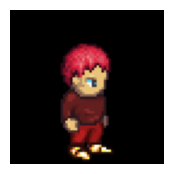

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08646773..1.0239861].


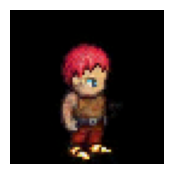

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08224359..1.042307].


tensor(6.6801, grad_fn=<MseLossBackward0>)
tensor(0.9131, grad_fn=<MseLossBackward0>)
Coming from =  tensor(25.6304, grad_fn=<MseLossBackward0>)
Distance parcourue : tensor(25.2589, grad_fn=<MseLossBackward0>)


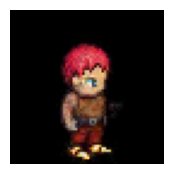

In [23]:
#Test en tant que denoiser

x= next(iter(val_loader))[2]
vae = vae.to('cpu')
model = model.to('cpu')

plt.figure(figsize=(2, 2))
plt.imshow(x.permute(1, 2, 0))
plt.axis('off')
plt.show()
#z = model.ldm.autoencoder_encode(x)
z = vae.encoder(x).embedding



t = torch.tensor([100])


noise = torch.randn_like(z)
noisy_z = model.ldm.add_noise(z, noise, t).float().reshape(-1, 3, 8, 8)

noisy_x = vae.decoder(noisy_z.reshape(-1, 192)).reconstruction

plt.figure(figsize=(2, 2))
plt.imshow(noisy_x[0].detach().permute(1, 2, 0))
plt.axis('off')
plt.show()

noise_pred= model.ldm(noisy_z, t)

print(nn.MSELoss(reduction = 'sum')(noise_pred.reshape(1, 192), noise))

#sampler = DDIMSampler(model.ldm, n_steps = 8)
# sampler = DDPMSampler(model.ldm)
# z_pred, _, _ = sampler.sample(shape=(1, 3, 8, 8), x_last = noisy_z, cond=None)


z_pred = (noisy_z - (1- model.ldm.alpha_bar[t]) ** 0.5 * noise_pred) / (model.ldm.alpha_bar[t] ** 0.5)
z_pred = z_pred.reshape(-1, 192).float()

#z_pred = z 

print(nn.MSELoss(reduction = 'sum')(z_pred, z.reshape(-1, 192)))
print('Coming from = ', nn.MSELoss(reduction = 'sum')(z, noisy_z.reshape(-1, 192)))
print('Distance parcourue :', nn.MSELoss(reduction = 'sum')(z_pred, noisy_z.reshape(-1, 192)))

#x_pred = model.ldm.autoencoder_decode(z_pred)
x_pred = vae.decoder(z_pred).reconstruction

plt.figure(figsize=(2, 2))
plt.imshow(x_pred[0].detach().permute(1, 2, 0))
plt.axis('off')
plt.show()






Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.121744..1.0966247].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.13893278..1.0967637].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08338704..1.1104612].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1371386..1.3067808].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08320954..1.067285].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10408106..1.0570226].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1005

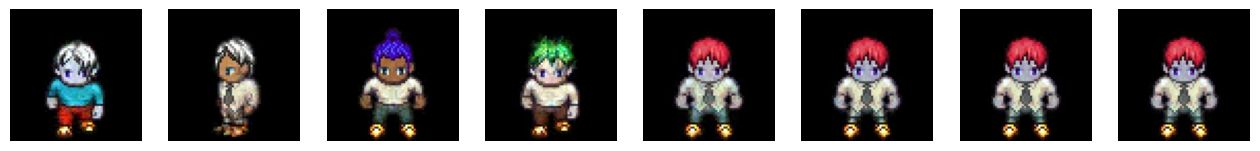

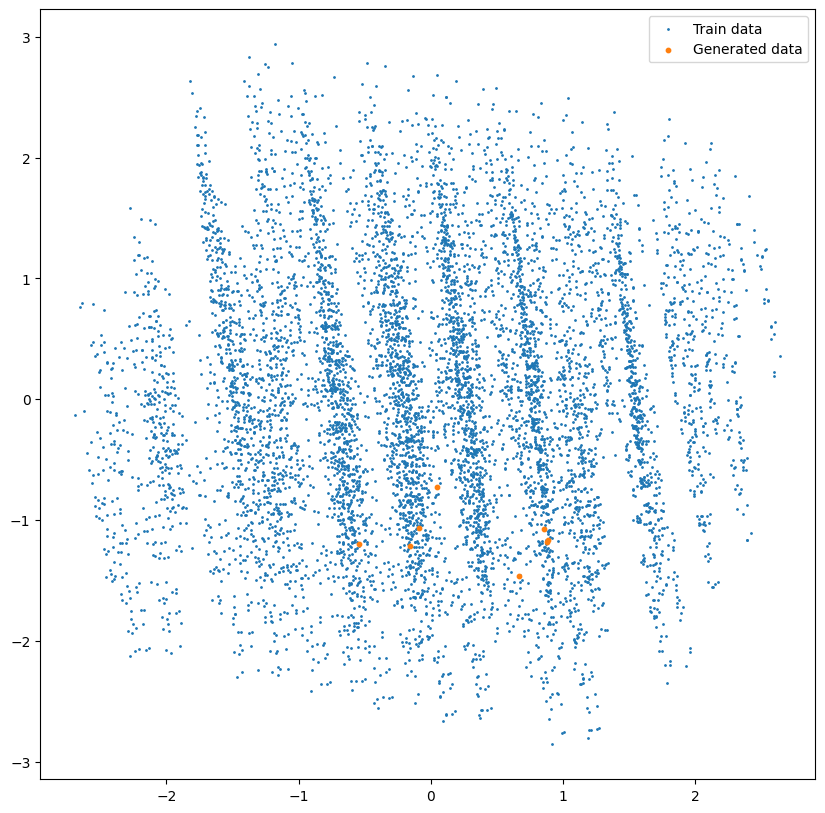

In [24]:
#Generation



vae = vae.to('cpu')
model = model.to('cpu')
sampler = DDIMSampler(model.ldm, n_steps = 8, ddim_eta  = 1)
#sampler = DDPMSampler(model.ldm)

start = torch.randn(1, 3, 8, 8).to('cpu')
#z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None,selected_time_steps = [i* 999 // 7 for i in range(8)])
z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None)
z = z.reshape(-1, 192).float()
x = vae.decoder(z).reconstruction.reshape(-1, 3, 64, 64)


all_z = all_z.squeeze(1).reshape(-1, 3*8*8)
all_pred_z0 = all_pred_z0.squeeze(1).reshape(-1, 3*8*8)

all_x = vae.decoder(all_z).reconstruction.reshape(-1, 3, 64, 64)
all_pred_x0 = vae.decoder(all_pred_z0).reconstruction.reshape(-1, 3, 64, 64)




plt.figure(figsize=(16, 24))
for i in range(8):
    plt.subplot(1, 8, i+1)
    #plt.imshow(all_x[12*i].detach().permute(1, 2, 0))
    plt.imshow(all_x[i].detach().permute(1, 2, 0))
    plt.axis('off')
plt.show()

# plt.figure(figsize=(16, 24))
# for i in range(8):
#     plt.subplot(1, 8, i+1)
#     plt.imshow(all_pred_x0[i].detach().permute(1, 2, 0))
#     plt.axis('off')
# plt.show()


train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
start = start.reshape(-1, 192).float()
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings.detach().numpy())

all_z_pca = pca.transform(all_z.detach().numpy())

plt.figure(figsize=(10, 10))
plt.scatter(train_pca[:, 0], train_pca[:, 1], label='Train data', s= 1)
plt.scatter(all_z_pca[:, 0], all_z_pca[:, 1], s = 10, label='Generated data')
plt.legend()
plt.show()


# plt.figure(figsize=(10, 10))
# for i in range(25):
#     plt.subplot(5, 5, i+1)
#     plt.imshow(x[i].detach().permute(1, 2, 0))
#     plt.axis('off')
# plt.show()


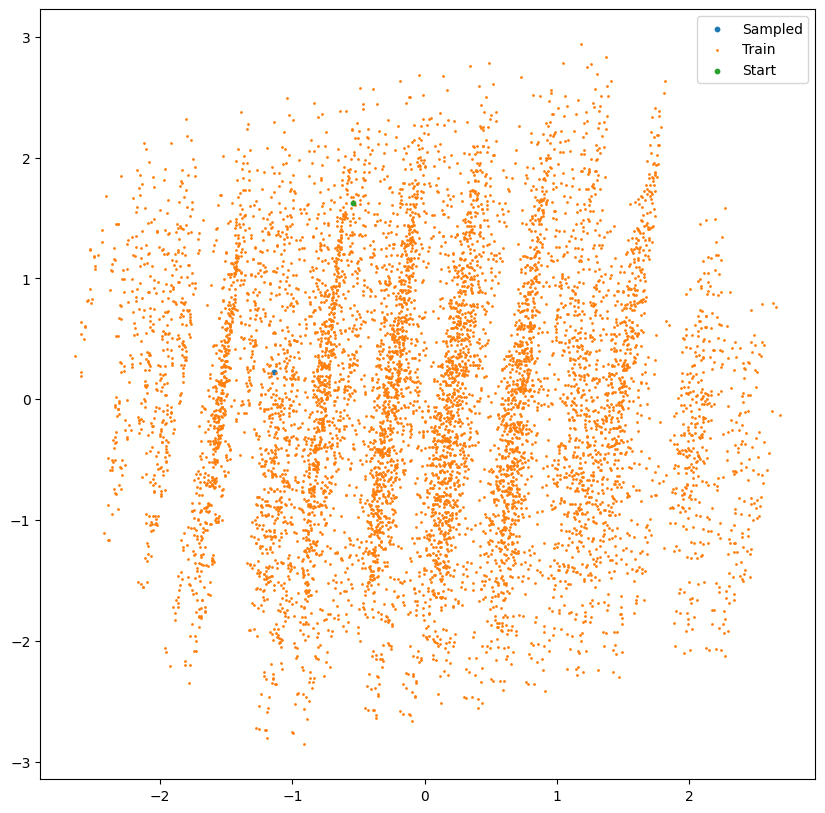

In [46]:
train_embeddings = vae.encoder.to('cpu')(train_dataset.data).embedding
start = start.reshape(-1, 192).float()
pca = PCA(n_components=2)
train_pca = pca.fit_transform(train_embeddings.detach().numpy())
z_pca = pca.transform(z.detach().numpy())
start_pca = pca.transform(start.detach().numpy())


plt.figure(figsize=(10, 10))
plt.scatter(z_pca[:, 0], z_pca[:, 1], s=10, label = "Sampled")
plt.scatter(train_pca[:, 0], train_pca[:, 1], s=1, label = "Train")
plt.scatter(start_pca[:, 0], start_pca[:, 1], s=10, label = "Start")
plt.legend()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07041018..1.0712268].


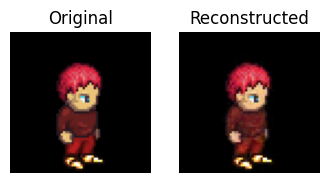

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07183669..1.0694515].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.066626586..1.0473423].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06549728..1.0539901].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.093888275..1.1378814].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11747462..1.1998663].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.11615578..1.0814033].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-

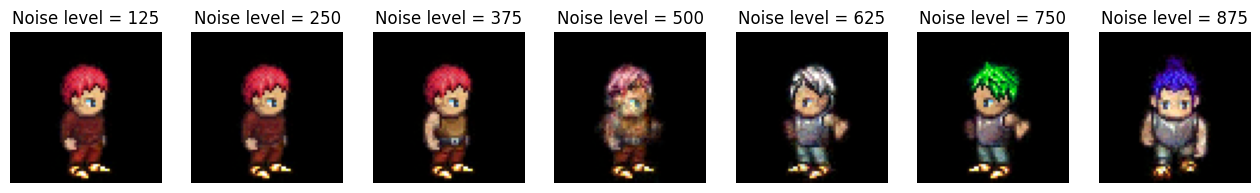

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.18803303..1.1022253].
/home/mtayebje/miniconda3/lib/python3.12/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 192])) that is different to the input size (torch.Size([192])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.14392856..1.1002893].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1933988..1.1972467].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.19319616..1.1969998].
Clipping input data to the valid range for imshow with 

tensor(90.2250, grad_fn=<MseLossBackward0>)
Baseline2:  tensor(43.9819, grad_fn=<MseLossBackward0>)
Baseline3:  tensor(52.0127, grad_fn=<MseLossBackward0>)
tensor(52.7795, grad_fn=<MseLossBackward0>)
Baseline2:  tensor(33.8291, grad_fn=<MseLossBackward0>)
Baseline3:  tensor(32.1140, grad_fn=<MseLossBackward0>)
tensor(36.1574, grad_fn=<MseLossBackward0>)
Baseline2:  tensor(18.0182, grad_fn=<MseLossBackward0>)
Baseline3:  tensor(23.5552, grad_fn=<MseLossBackward0>)
tensor(27.9649, grad_fn=<MseLossBackward0>)
Baseline2:  tensor(9.2432, grad_fn=<MseLossBackward0>)
Baseline3:  tensor(20.4817, grad_fn=<MseLossBackward0>)
tensor(13.6339, grad_fn=<MseLossBackward0>)
Baseline2:  tensor(3.1234, grad_fn=<MseLossBackward0>)
Baseline3:  tensor(12.5892, grad_fn=<MseLossBackward0>)
tensor(8.2912, grad_fn=<MseLossBackward0>)
Baseline2:  tensor(0.8100, grad_fn=<MseLossBackward0>)
Baseline3:  tensor(8.5391, grad_fn=<MseLossBackward0>)
tensor(8.4546, grad_fn=<MseLossBackward0>)
Baseline2:  tensor(0., gra

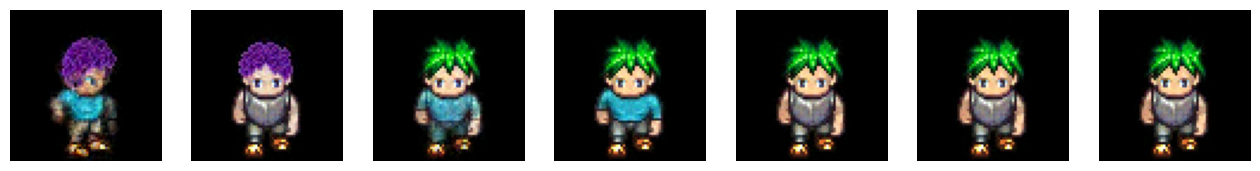

In [40]:
x = next(iter(val_loader))[2]
vae = vae.to('cpu')
model = model.to('cpu')
z_orig = vae.encoder(x).embedding.float()
x_rec = vae.decoder(z_orig).reconstruction.reshape(3, 64, 64).detach()
plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1)
plt.title('Original')
plt.imshow(x.permute(1, 2, 0))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title('Reconstructed')
plt.imshow(x_rec.permute(1, 2, 0))
plt.axis('off')
plt.show()

all_noisy_z = [z_orig]
plt.figure(figsize=(16, 24))
ts = [125*i for i in range(1, 8)]
for i in range(7):
    noise = torch.randn_like(z_orig)
    prev_z = all_noisy_z[-1]

    #noisy_z = model.ldm.add_noise(prev_z, noise, torch.tensor([125])).float()
    #noisy_z = model.ldm.add_noise(z_orig, noise, torch.tensor([ts[i]])).float()

    if i> 0:
        noisy_z = model.ldm.sequential_diffusion(prev_z, ts[i-1], ts[i], noise).float()
    else:
        noisy_z = model.ldm.sequential_diffusion(prev_z, 0, ts[i], noise).float()

    all_noisy_z.append(noisy_z)

    noisy_x = vae.decoder(noisy_z.reshape(-1, 192)).reconstruction.reshape(3, 64, 64).detach()

    plt.subplot(1, 7, i+1)
    plt.title('Noise level = ' + str(ts[i]))
    plt.imshow(noisy_x.permute(1, 2, 0))
    plt.axis('off')
plt.show()

sampler = DDIMSampler(model.ldm, n_steps = 7, ddim_eta = 1)
sampler.time_steps = ts
#sampler = DDPMSampler(model.ldm)


start = noisy_z.reshape(-1, 3, 8, 8)
#z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None, selected_time_steps=[i* 999 // 7 +1 for i in range(8)], temperature = 0)
z, all_z, all_pred_z0 = sampler.sample(shape=(1, 3, 8, 8), x_last = start, cond=None, temperature = 0.3)
z = z.reshape(-1, 192).float()
x = vae.decoder(z).reconstruction.reshape(-1, 3, 64, 64)


all_z = all_z.squeeze(1).reshape(-1, 3*8*8)

all_x = vae.decoder(all_z).reconstruction.reshape(-1, 3, 64, 64).detach()
plt.figure(figsize=(16, 24))
for i in range(7):
    plt.subplot(1, 7, i+1)
    #plt.title('Pred level ' + str(ts[-i-2]) + '|' + str(ts[-i-1]))
    plt.imshow(all_x[i].permute(1, 2, 0))
    plt.axis('off')
    z_pred = all_z[i]
    z_target = all_noisy_z[-i-2].reshape(-1, 192)
    print(nn.MSELoss(reduction = 'sum')(z_pred, z_target))
    print('Baseline2: ', nn.MSELoss(reduction = 'sum')(z_orig, z_target))
    print('Baseline3: ', nn.MSELoss(reduction = 'sum')(z_pred, z_orig))
plt.show()


In [54]:
from torchmetrics.image.fid import FrechetInceptionDistance


model = model.to('cpu')
vae = vae.to('cpu')
sampler = DDIMSampler(model.ldm, n_steps = 7, ddim_eta = 1)
start = torch.randn(1000, 3, 8, 8)
fake_images, _, _ = sampler.sample(shape=(1000, 3, 8, 8), x_last = start, cond=None, temperature = 1)

rand_indxes = torch.randint(0, 8000, (1000,))
real_images = vae.encoder(train_data[rand_indxes]).embedding.reshape(-1, 3, 8, 8)

fid = FrechetInceptionDistance(normalize=True)
fid.update(real_images, real=True)
fid.update(fake_images, real=False)

print(fid.compute())


tensor(11.8533)
